<a href="https://colab.research.google.com/github/EnesCaliskan/ImageToTextCNN/blob/main/Exam_1_06_12_2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torch import nn
from torchvision import models
from torchsummary import summary

In [ ]:
from PIL import Image
import requests
from io import BytesIO
import numpy as np
import matplotlib.pyplot as plt

response = requests.get("https://www.assemblyai.com/blog/content/images/2022/07/Build-Your-Own-Imagen-Text-to-Image-Model.png")
image = Image.open(BytesIO(response.content)).convert('RGB')
image = image.resize((1024, 1024))
image = np.rollaxis(np.array(image), 2, 0)

In [ ]:
image.shape

(3, 1024, 1024)

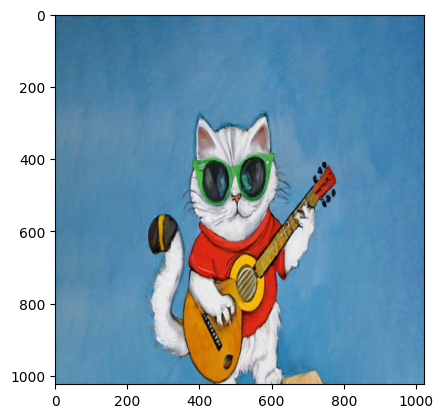

In [ ]:
plt.imshow(np.moveaxis(image, 0,-1))

In [ ]:
#Simple pre-processing
input_image = torch.from_numpy(image)
input_image = torch.unsqueeze(input_image, dim=0)
input_image.size()

torch.Size([1, 3, 1024, 1024])

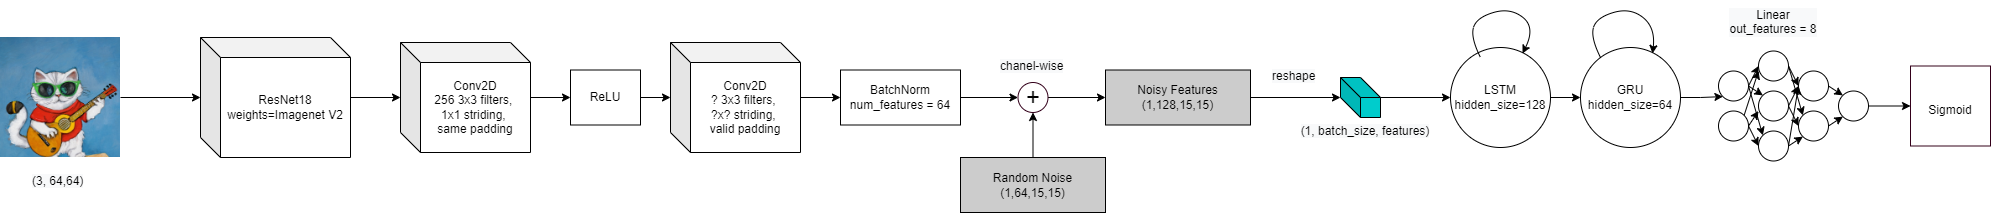

In [ ]:
class ImageToText(nn.Module):
    def __init__(self):
        super(ImageToText, self).__init__()

        ### WEIGHT EKLEME
        resnet18 = models.resnet18(weights = models.ResNet18_Weights.DEFAULT)
        ### RESNET18 MODELININ SON 2 KATMANINI CIKARMA
        self.resnet18 = nn.Sequential(*list(resnet18.children())[:-2])

        self.conv1 = nn.Conv2d(in_channels=512, out_channels=256, kernel_size=(3,3), stride=(1,1), padding='same')
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=256, out_channels=64, kernel_size=(3,3), stride=(2,2), padding='valid') ### stride ve out_channel ?
        self.batch_norm = nn.BatchNorm2d(num_features= 64)
        ### NOISE EKLEME
        self.noise = torch.rand(1,64,15,15)

        self.lstm = nn.LSTM(input_size= 1*128*15*15, hidden_size = 128)
        self.lstm2 = nn.LSTM(input_size= 128, hidden_size = 64)
        self.linear = nn.Linear(in_features = 64, out_features= 8)
        self.sigmoid = nn.Sigmoid()




    def forward(self, image):

        batch_size = image.size(0)

        resnet18_out = self.resnet18(image)
        print('resnet18_out: ', resnet18_out.shape)

        conv1_out = self.conv1(resnet18_out)
        print('conv1_out: ', conv1_out.shape)

        relu1_out = self.relu1(conv1_out)
        print('relu1_out: ', relu1_out.shape)

        conv2_out = self.conv2(relu1_out)
        print('conv2_out: ', conv2_out.shape)

        batch_norm_out = self.batch_norm(conv2_out)
        print('batch_norm_out: ', batch_norm_out.shape)

        combined1 = torch.cat((batch_norm_out, self.noise), dim=1)
        print('combined1: ', combined1.shape)

        flatten = combined1.reshape(1, batch_size, 1*128*15*15)
        print('flatten: ', flatten.shape)

        lstm1_out, _ = self.lstm(flatten)
        print('lstm1_out: ', lstm1_out.shape)

        lstm2_out, out = self.lstm2(lstm1_out)
        print('lstm1_out: ', lstm1_out.shape)

        linear_out = self.linear(lstm2_out)
        print('linear_out: ', lstm1_out.shape)

        sigmoid_out = self.sigmoid(linear_out)
        print('sigmoid_out: ', sigmoid_out.shape)

        #SEND the image to the resnet18 and the convolutional layers



        return sigmoid_out #rename your last output as predictions, or change the name here

In [ ]:
imagetotext = ImageToText()

output = imagetotext(input_image.float())

list(output.shape) == [1,1,8]


resnet18_out:  torch.Size([1, 512, 32, 32])
conv1_out:  torch.Size([1, 256, 32, 32])
relu1_out:  torch.Size([1, 256, 32, 32])
conv2_out:  torch.Size([1, 64, 15, 15])
batch_norm_out:  torch.Size([1, 64, 15, 15])
combined1:  torch.Size([1, 128, 15, 15])
flatten:  torch.Size([1, 1, 28800])
lstm1_out:  torch.Size([1, 1, 128])
lstm1_out:  torch.Size([1, 1, 128])
linear_out:  torch.Size([1, 1, 128])
sigmoid_out:  torch.Size([1, 1, 8])


True

Expected Output = ([1, 1, 8])